# Project with convolutional neural networks (CNN)

In this project, we used an American Sign Language (ASL) database. It contains 87000 images of 200x200 pixels. There are 29 classes: letters A-Z, SPACE, DELETE and NOTHING. These last 3 classes are very helpful in real time applications, and classification. We reduced the size of the database, namely mini_ASL, which contains 100 image per letter. The test data set contains a mere 29 images (equal to the original database), to encourage the use of real world test images. However, in this project, we will test the models with a partition of the train dataset by the use of one scikitlearn function.

## Importing the necessary libraries

In [1]:
# import tensorflow.contrib.eager as tfe
# Enable eager execution
# tfe.enable_eager_execution()

# Imports for Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# ensure consistency across runs
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt


## Loading the data

In [2]:
!wget https://www.dropbox.com/s/x46u9ibdw5ph3t7/mini_asl_alphabet.zip
!unzip mini_asl_alphabet.zip

--2019-04-15 19:39:36--  https://www.dropbox.com/s/x46u9ibdw5ph3t7/mini_asl_alphabet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x46u9ibdw5ph3t7/mini_asl_alphabet.zip [following]
--2019-04-15 19:39:36--  https://www.dropbox.com/s/raw/x46u9ibdw5ph3t7/mini_asl_alphabet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2101089752e36b672b67d71661.dl.dropboxusercontent.com/cd/0/inline/AfGfcftikGutKRdV3TxHS__Pe-ZNPP9Jwst64U6ZWSH3NFBE6sc46Nrzif8Tc8s6mvromiuEEYif8g5ARFVbEIapxTBUiRqfS9i08PROjV-kiPSdPboeWCrGp_ZOXJBvpf8/file# [following]
--2019-04-15 19:39:37--  https://uc2101089752e36b672b67d71661.dl.dropboxusercontent.com/cd/0/inline/AfGfcftikGutKRdV3TxHS__Pe-ZNPP9Jwst64U6ZWSH3NFBE6sc46Nrzif8Tc8s6mvromiuEEYif8g5ARFVbEIa

In [2]:
TRAIN_DIR = './mini_asl_alphabet/asl_alphabet_train'
TEST_DIR = './mini_asl_alphabet/asl_alphabet_test'

classes = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]

classes.sort()
num_classes = len(classes)

target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB

Next, we read each image of the dataset with its associated label, every image is resized from 200x200 to 64x64 for simplicity and we realized the one-hot encoding. Finally, we plot a sample of every letter.

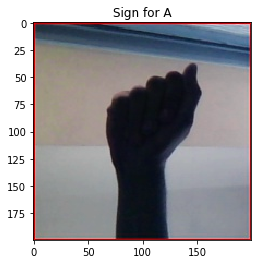

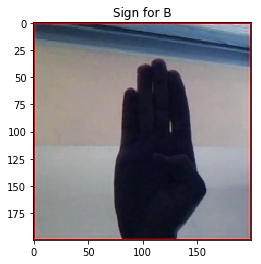

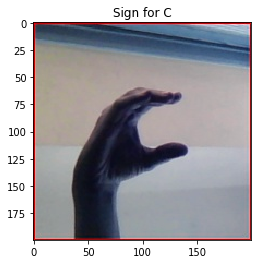

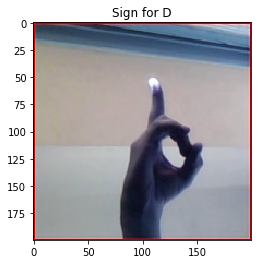

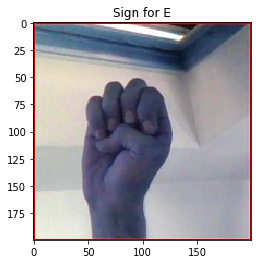

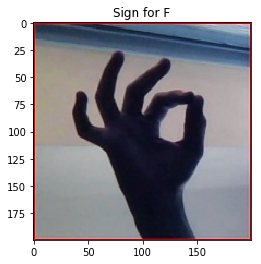

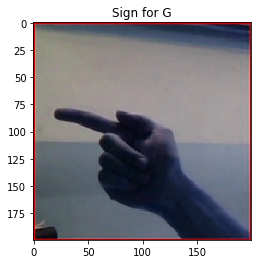

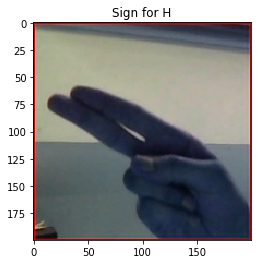

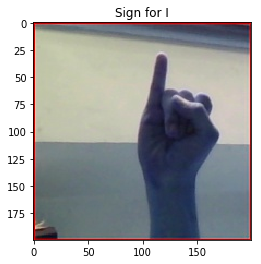

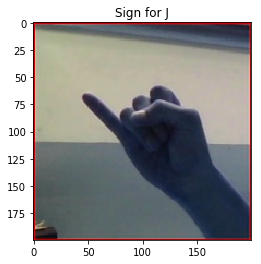

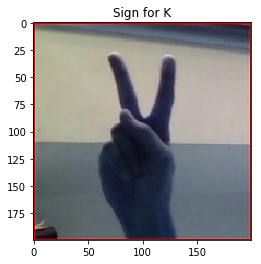

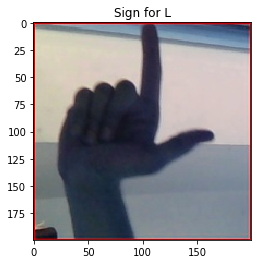

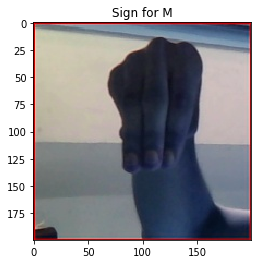

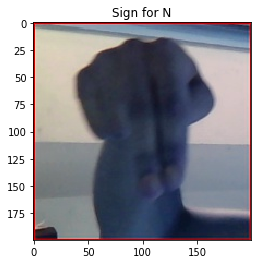

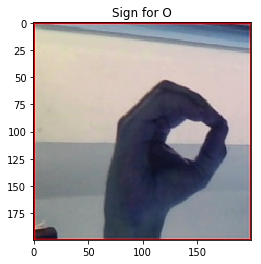

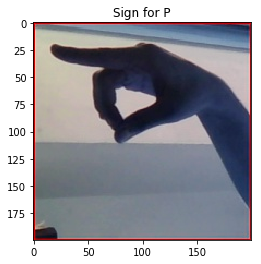

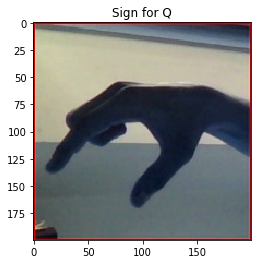

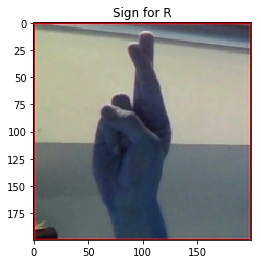

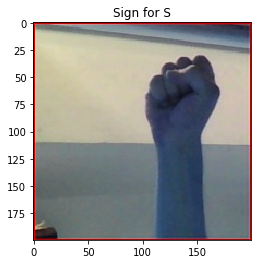

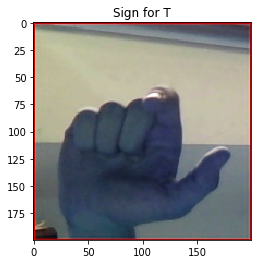

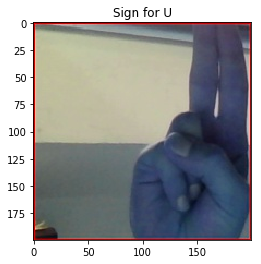

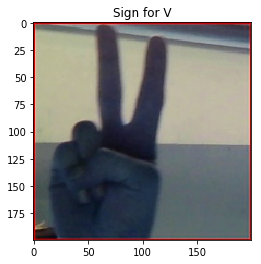

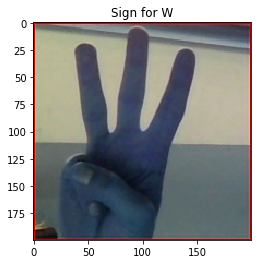

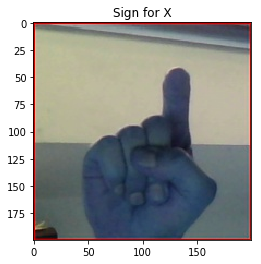

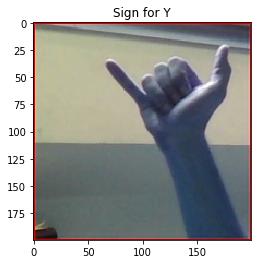

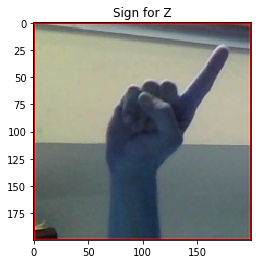

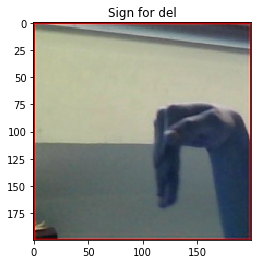

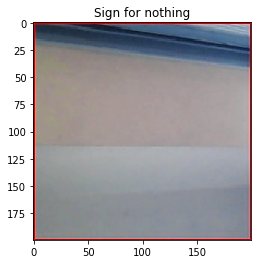

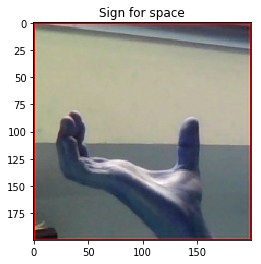

In [3]:
X = []
y = []
label = 0
for letter in classes:
    base_path = TRAIN_DIR
    img_path = base_path + '/' + letter + '/**'
    path_contents = glob(img_path)
    
    for i in range(100):
        big_img = cv2.imread(path_contents[i])
        resized_img = cv2.resize(big_img, target_size)
        X.append(resized_img)
        y.append(label)
        
        if i == 50:
            plt.imshow(cv2.imread(path_contents[i]))
            plt.title('Sign for '+letter)
            plt.show()
    
    label +=1

In [4]:
data_dir = TRAIN_DIR

val_frac = 0.1
batch_size = 64
num_epochs = 30
workers = 48

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

test_datagen = ImageDataGenerator(samplewise_center=True, 
                                  samplewise_std_normalization=True)

train_generator = data_augmentor.flow_from_directory(data_dir, 
                                                     target_size=target_size, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     subset = "training")

val_generator = data_augmentor.flow_from_directory(data_dir, 
                                                   target_size=target_size, 
                                                   batch_size=batch_size,
                                                   shuffle = False,
                                                   subset = "validation")

test_generator = test_datagen.flow_from_directory(directory=r"./mini_asl_alphabet/asl_alphabet_test",
                                                  target_size=(64, 64),
                                                  color_mode="rgb",
                                                  batch_size = 1,
                                                  class_mode = None,
                                                  shuffle = False,
                                                  seed = 42)

Found 2610 images belonging to 29 classes.
Found 290 images belonging to 29 classes.
Found 29 images belonging to 2 classes.


## Comparation of different CNN Models

Next, we compared four different architectures of CNN:

## Creating the model

### Model A:

We designed a CNN with 1 convolutional as follows:
$$W[10,10,3,8]$$ 8 filters x 10x10 x 3 (RGB) + 8 (bias) = 2408 parameters

We applied 2 dense layers, the first one with 64 layers and the last layer with 29 outputs.
Furhtermore, we applied dropout after the convolutional layer and before the output layer, in order the avoid overfitting

In [5]:
def get_conv_model_A(num_classes, img_shape = target_dims, compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(8, kernel_size = 10, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [6]:
model = get_conv_model_A(num_classes)
model.summary()
historyModelA = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 8)         2408      
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 24200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1548864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1885      
Total params: 1,553,157
Trainable params: 1,553,157
Non-trainable params: 0
_________________________________________________________________


### Model B:

We designed a CNN with 1 convolutional as follows:
$$W[10,10,3,64]$$ 64 filters x 10x10 x 3 (RGB) + 64 (bias) = 19264 parameters

We applied 2 dense layers, the first one with 64 layers and the last layer with 29 outputs.
Furhtermore, we applied dropout after the convolutional layer and before the output layer, in order the avoid overfitting, but the last dropout was reduced to 20% of the weights.

Model B is harder to train than model A, since A has 1,553,157 parameters whereas model B has 12,411,613!!!

In [7]:
def get_conv_model_B(num_classes, img_shape = target_dims, compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size = 10, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [8]:
model = get_conv_model_B(num_classes)
model.summary()
historyModelB = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 64)        19264     
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12390464  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1885      
Total params: 12,411,613
Trainable params: 12,411,613
Non-trainable params: 0
________________________________________________________________

### Model C:

We designed a CNN with 2 convolutional as follows:
$$W_1[5,5,3,64]$$ 64 filters x 5x5 x 3 (RGB) + 64 (bias) = 4864 parameters
$$W_2[5,5,64,64]$$ 64 filters x 5x5 x 64 (input) + 64 (bias) = 102464 parameters

We applied 2 dense layers, the first one with 64 layers and the last layer with 29 outputs.
Furhtermore, we applied three dropout stages, one after each convolutional layer (50% of the weights) and before the output (20% of the weights).

Model C has a bit more number of parameters than model B (12,954,333)

In [9]:
def get_conv_model_C(num_classes, img_shape = target_dims, compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size = 5, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, kernel_size = 5, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [10]:
model = get_conv_model_C(num_classes)
model.summary()
historyModelC = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        4864      
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        102464    
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12845120  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

### Model D:

We designed a CNN with 6 convolutional and 2 dense layers:
$$W_1[4,4,3,64]$$ 64 filters x 4x4 x 3 (RGB) + 64 (bias) = 3136 parameters
$$W_2[4,4,64,64]$$ 64 filters x 4x4 x 64 filters (prev. conv. layer - input) + 64 (bias) = 65600 parameters
$$W_3[4,4,32,128]$$ 128 filters x 4x4 x 64 filters (input channels) + 128 (bias) = 131200 parameters
$$W_4[4,4,32,128]$$ 128 filters x 4x4 x 128 filters (input channels) + 128 (bias) = 262272 parameters
$$W_5[4,4,64,256]$$ 256 filters x 4x4 x 128 filters (input channels) + 256 (bias) = 524544 parameters
$$W_6[4,4,128,256]$$ 256 filters x 4x4 x 256 filters (input channels) + 256 (bias) = 1048832 parameters

The difference between each pair of convolutional layers with the same number of filters, was the stride; in the first we applied a shifting of one pixel, whereas in the second layer we moved two pixels between convolutions (stride = 2). Additionally, we applied dropout over the 50% of the weights after each pair of convolutional layers: after the layers of 64 filters, 128 and 256, as well as before the 512 fully connected layer.

Although this model has more convolutional layers than the above built, it has only 3,230,621 parameters

In [11]:
def get_conv_model_D(num_classes, img_shape=target_dims, compile = True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [12]:
model = get_conv_model_D(num_classes)
model.summary()
historyModelD = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 256)         524544    
__________

## Evaluating the model

In order to evaluate the model, the learning curves of the trained models were computed.

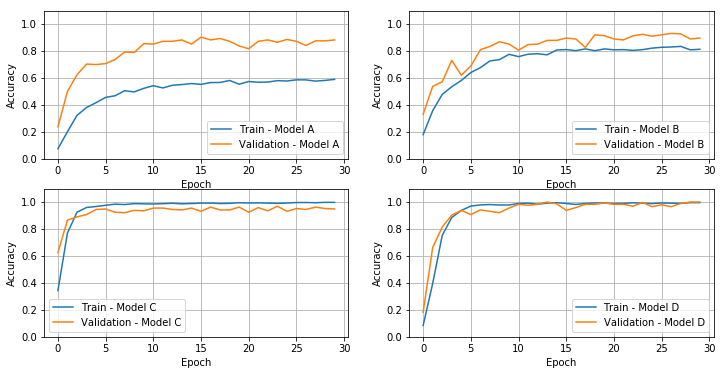

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

def plotResults(history, label = ['A', 'B', 'C', 'D']):
    for i in range(len(history)):
        plt.subplot(len(history) // 2, len(history) // 2 + len(history) % 2, i + 1)
        plt.ylim(0,1.1)
        plt.grid()
        plt.plot(history[i].history['acc'], label='Train - Model ' + label[i])
        plt.plot(history[i].history['val_acc'], label='Validation - Model ' + label[i])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()

plotResults([historyModelA, historyModelB, historyModelC, historyModelD])

The learning curves show that the highest performance was achieved by the model D, since the validation curve reaches almost 100% of accuracy. The model C exhibits overfitting, because the accuracy in the training set reaches 100% rapidly, but the validation set shows accuracy near to 90%. Although its performance is not poor, bearing in mind the high amount of parameters in comparison with model D, the most obvious decision is to disregard the model C: lower performance and higher computational cost. The worst model is B, which lead us to highlight that the amount of parameters is not enough to suspect a good performance. In contrast, models with less parameters could behave better, such as model A or model D (the best, in this case). Particularly, the best model has the highest number of convolutional layers. Additionally, the designer must be careful in order to prevent overfitting. In this case, we carried out the dropout to do this.

In [14]:
model.save('modelD.mod')

We saved the model, and was reloaded.

In [6]:
model = load_model('modelD.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Additionally, we plotted the confusion matrix of the model D:

In [7]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

5/5 [==============================] - 1s 185ms/step
Accuracy = 98.9655172413793%
Normalized confusion matrix


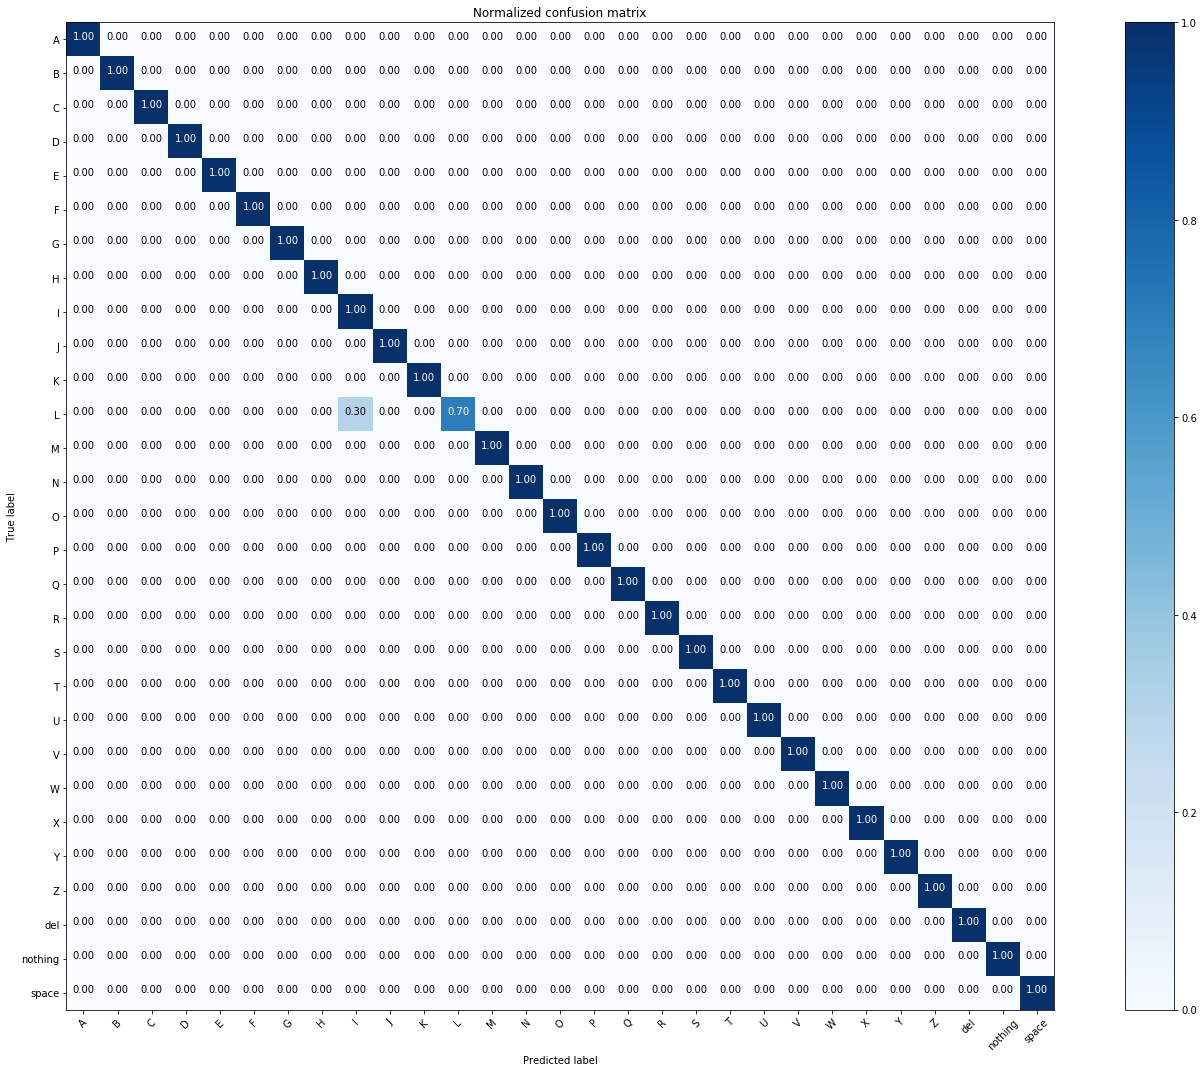

In [8]:
import numpy as np

val_generator.reset()
preds = model.predict_generator(val_generator,verbose=1).argmax(axis = 1)

Accuracy = np.mean(preds == val_generator.classes)
print("Accuracy = " + str(Accuracy*100) + "%")

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_generator.classes, preds)
np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plt.figure(figsize=(20,15))
plot_confusion_matrix(cnf_matrix, classes=val_generator.class_indices, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

It is evident the optimal behavior of the chosen CNN, without misleading classes.

##  And if we try with the test dataset?

We used the flow_from_dataframe from the Keras’s ImageDataGenerator to perform image augmentation. Further information in the following link: [Tutorial on Keras flow_from_dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

We returned the test set as follows:

In [13]:
import pandas as pd

testdf=pd.read_csv("./mini_asl_alphabet/testDataframe.csv",dtype=str)

test_generator = test_datagen.flow_from_dataframe(dataframe = testdf,
                                                directory=r"./mini_asl_alphabet/asl_alphabet_test/test/",
                                                x_col="id",
                                                y_col="label",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(64,64))


#preds = model.predict_generator(val_generator,verbose=1).argmax(axis = 1)
test_generator.reset()
pred = model.predict_generator(test_generator, verbose=1).argmax(axis=1)

Found 29 images.
1/1 [==============================] - 0s 131ms/step


In [14]:
testdf['prediction'] = pred
testdf

,id,label,prediction
0,A_test.jpg,0,12
1,B_test.jpg,1,1
2,C_test.jpg,2,2
3,D_test.jpg,3,3
4,E_test.jpg,4,18
5,F_test.jpg,5,5
6,G_test.jpg,6,6
7,H_test.jpg,7,7
8,I_test.jpg,8,8
9,J_test.jpg,9,9


Accuracy = 93.10344827586206%
Normalized confusion matrix


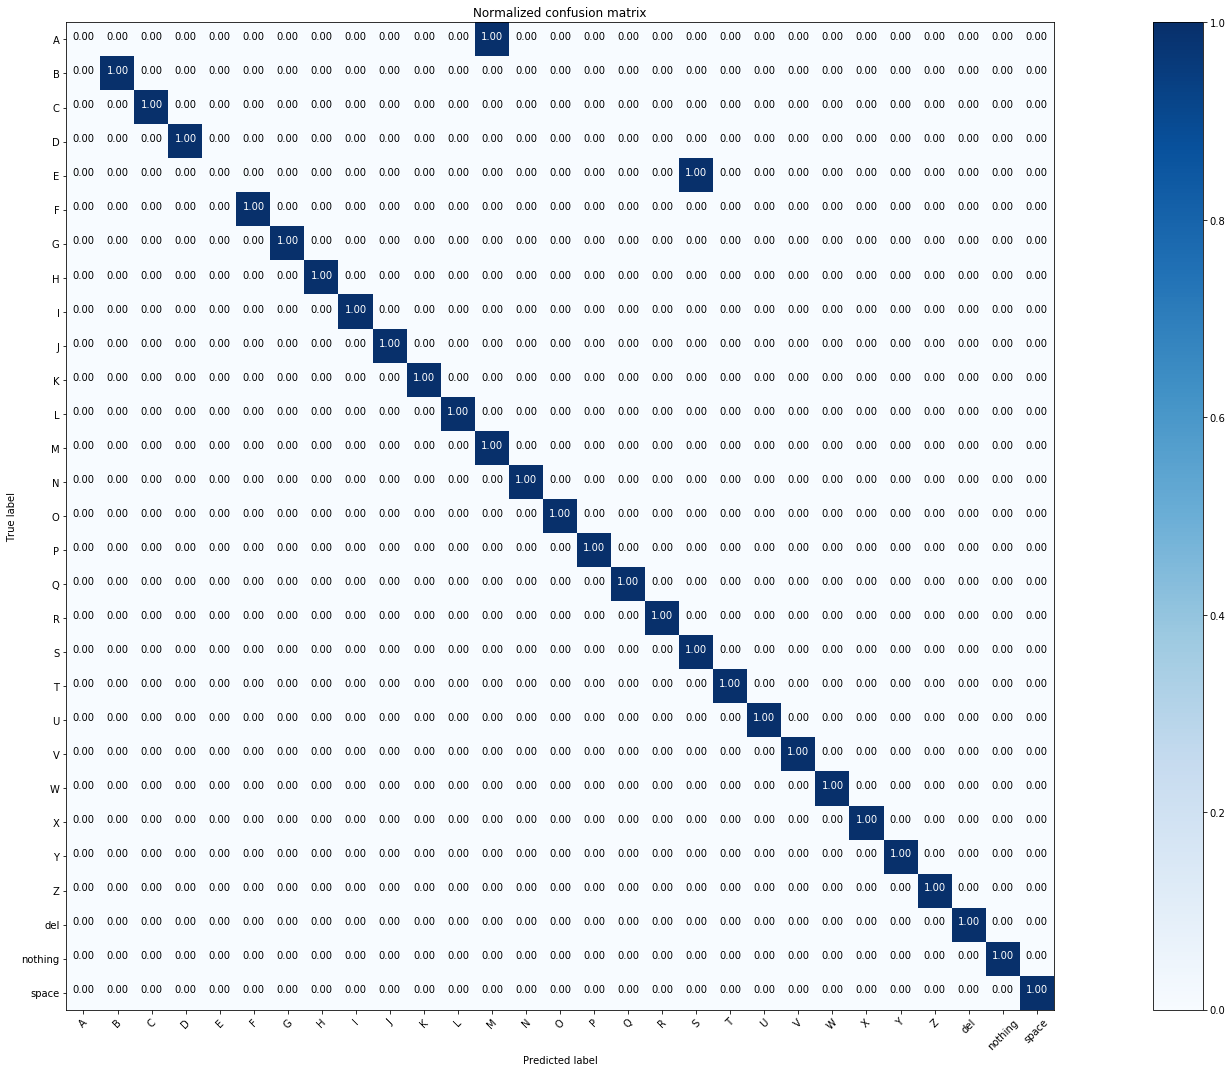

In [15]:
test_pred = np.array(testdf['prediction'])
test_target = np.array(testdf['label'].astype(int))

Accuracy = np.mean(test_target == test_pred)
print("Accuracy = " + str(Accuracy*100) + "%")

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target, test_pred)
np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plt.figure(figsize=(28,15))
plot_confusion_matrix(cnf_matrix, 
                      classes=val_generator.class_indices, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The accuracy with the test dataset shows good results, we expected these results because of the training and validation results.

## Let's play with transfer learning

 Next, we imported the pretrained network AlexNet. We returned the first two convolutional layers: 

In [18]:
import pickle, bz2

#!ls -lash data/alexnet_conv1_conv2.pklz
#!ls -lash alexnet_conv1_conv2.pklz

Observe that the second convolutional layer has 256 filters of 5x5, but 48 input channels. Bearing in mind that the first layers has 96 filters, we decided to work only with the first one. 

In [19]:
# OJO --- CAMBIAR UBICACIÓN DE PKLZ

alex_c12 = pickle.load(bz2.BZ2File("alexnet_conv1_conv2.pklz", "r"))
for k,(w,b) in alex_c12.iteritems():
    print k, b.shape, w.shape

alex_w1 = alex_c12["conv1"][0]
print alex_w1.shape

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)
(11, 11, 3, 96)


Bearing in mind the shape of the first convolutional layer, we created a new model based on the model D but with the same shape in the first layer as AlexNet:

In [20]:
def get_conv_model_D_Alex(num_classes, img_shape=target_dims, compile = True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(96, kernel_size=11, strides=1, activation='relu', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [21]:
modelAlex = get_conv_model_D_Alex(num_classes)
modelAlex.summary()
historyModelD = modelAlex.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        98368     
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         524544    
__________

We verified that the shape of the weights of the first convolutional layer of the model is the same as the AlexNet:

In [22]:
w = modelAlex.get_weights()
for i in w:
    print i.shape

(11, 11, 3, 96)
(96,)
(4, 4, 96, 64)
(64,)
(4, 4, 64, 128)
(128,)
(4, 4, 128, 128)
(128,)
(4, 4, 128, 256)
(256,)
(4, 4, 256, 256)
(256,)
(1024, 512)
(512,)
(512, 29)
(29,)


Subsequently, we imported the filters of the first level of the AlexNet, and we showed them:

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


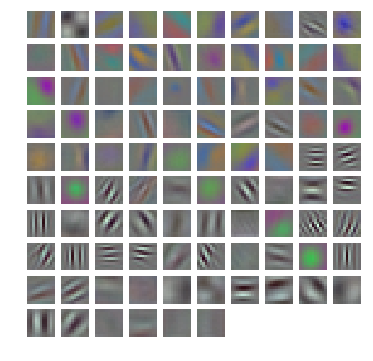

In [23]:
import mlutils

w[0] = alex_w1
mlutils.display_imgs(w[0])

These weights were loaded into the model:

In [24]:
modelAlex.set_weights(w)

Finally, we trained the latter model and computed its accuracy, learning plot and confusion matrix:

In [25]:
historyModelAlex = modelAlex.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)

Epoch 1/30
41/41 [==============================] - 283s 7s/step - loss: 3.8380 - acc: 0.0367 - val_loss: 3.3677 - val_acc: 0.0345
Epoch 2/30
41/41 [==============================] - 276s 7s/step - loss: 3.3700 - acc: 0.0353 - val_loss: 3.3676 - val_acc: 0.0345
Epoch 3/30
41/41 [==============================] - 281s 7s/step - loss: 3.3707 - acc: 0.0310 - val_loss: 3.3675 - val_acc: 0.0345
Epoch 4/30
41/41 [==============================] - 280s 7s/step - loss: 3.3681 - acc: 0.0353 - val_loss: 3.3674 - val_acc: 0.0345
Epoch 5/30
41/41 [==============================] - 280s 7s/step - loss: 3.3684 - acc: 0.0318 - val_loss: 3.3674 - val_acc: 0.0345
Epoch 6/30
41/41 [==============================] - 280s 7s/step - loss: 3.3685 - acc: 0.0301 - val_loss: 3.3674 - val_acc: 0.0345
Epoch 7/30
41/41 [==============================] - 272s 7s/step - loss: 3.3679 - acc: 0.0291 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 8/30
41/41 [==============================] - 281s 7s/step - loss: 3.3682 - a

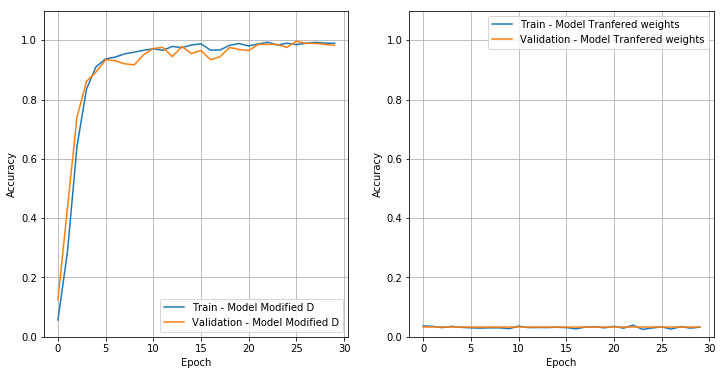

In [26]:
plt.figure(figsize=(12,6))

def plotResults2(history, label = ['Modified D', 'Tranfered weights']):
    for i in range(len(history)):
        plt.subplot(1, 2, i + 1)
        plt.ylim(0,1.1)
        plt.grid()
        plt.plot(history[i].history['acc'], label='Train - Model ' + label[i])
        plt.plot(history[i].history['val_acc'], label='Validation - Model ' + label[i])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()

plotResults2([historyModelD, historyModelAlex])

It is clear that the AlexNet weights did not work at all. Basically, the model could not learn. As observed in the left plot, it this behavior is not due to the architecture per se, but the values of the weights of the AlexNet. Observe that behavior before the transfer is very well. We hypothesize that the extremely poor behavior is due to the nature of the images that we used; all images were classified as closed hand (letter S). This is observed in the confusion matrix:

5/5 [==============================] - 10s 2s/step
Accuracy = 3.4482758620689653%
Normalized confusion matrix


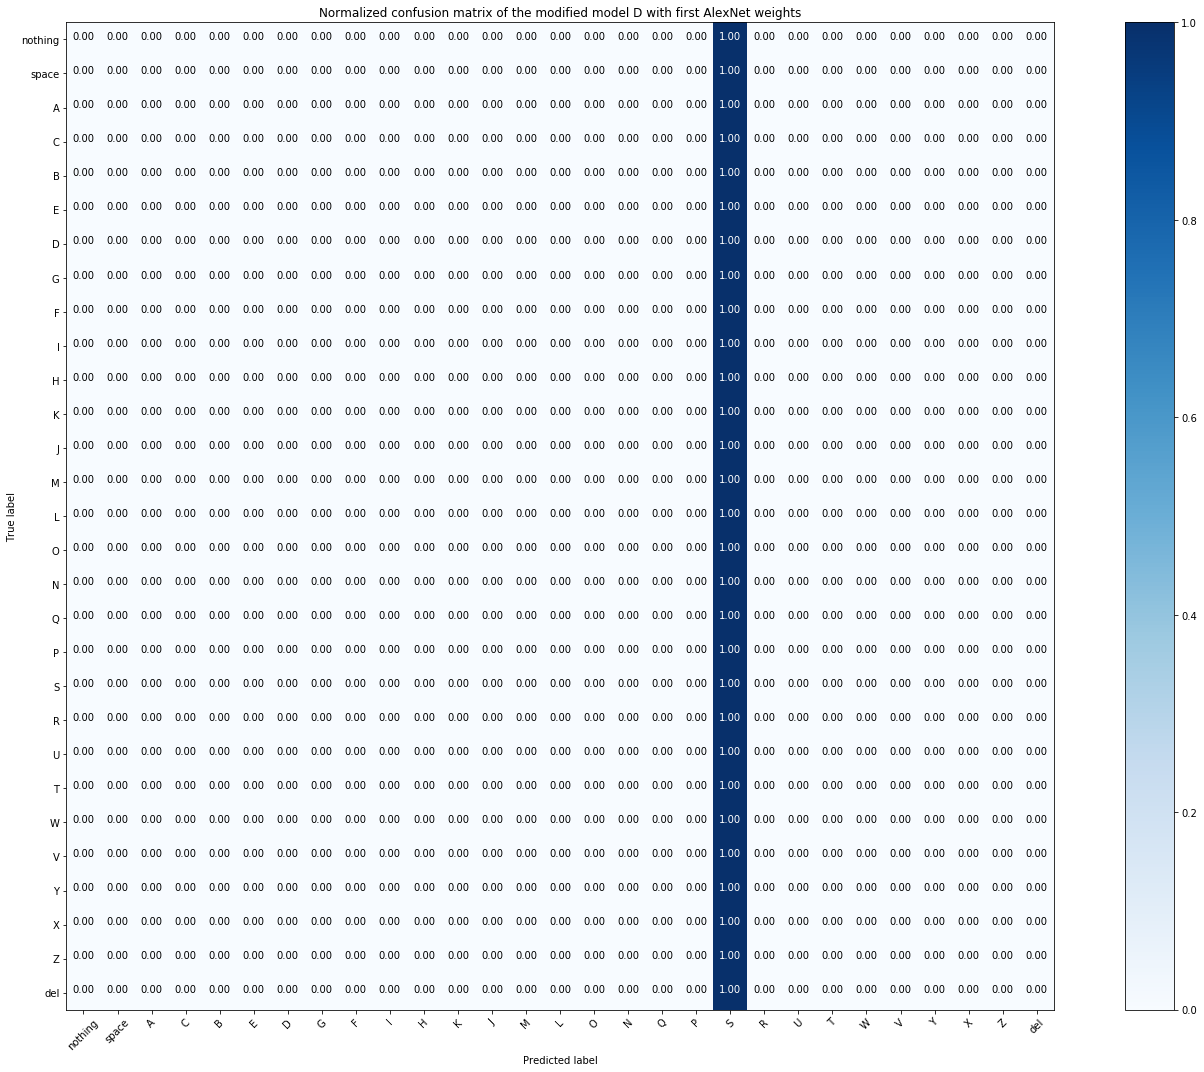

In [27]:
val_generator.reset()
preds = modelAlex.predict_generator(val_generator,verbose=1).argmax(axis = 1)

Accuracy = np.mean(preds == val_generator.classes)
print("Accuracy = " + str(Accuracy*100) + "%")

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_generator.classes, preds)
np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plt.figure(figsize=(20,15))
plot_confusion_matrix(cnf_matrix, classes=val_generator.class_indices, 
                      normalize=True,
                      title='Normalized confusion matrix of the modified model D with first AlexNet weights')

plt.show()